# LGBM을 이용한 발전양 예측

# Data

In [1]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# warnings.filterwarnings("ignore")
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

df_train = pd.read_csv('train/train.csv')
submission = pd.read_csv('sample_submission.csv')

dfs_valid = []

for i in range(81):
    temp_df = pd.read_csv(f"test/{i}.csv")
    dfs_valid.append(temp_df.copy())

In [2]:
import math
    
def Make_New_Features(df_train):
    df_train['GHI'] = df_train['DHI'] + df_train['DNI']
    df_train['RDHNI'] = df_train['GHI'].apply(lambda x : x**0.5)
    df_train['GHI_East'] = df_train['DHI'] + df_train['DNI'] * math.cos(0.436332)
    df_train['GHI_West'] = df_train['DHI'] - df_train['DNI'] * math.cos(0.436332)
#====================================================================================
    df_train['Lower_Cloud'] = 2.5 * df_train['RH'] / 100 - 1.5
    df_train['Middle_Cloud'] = 4 * df_train['RH'] / 100 - 3.0
#====================================================================================
    b = 17.62
    c = 243.12
    df_train['gamma'] = (b * df_train['T'] /(c + df_train['T'])) + (df_train['RH'] / 100.0).apply(lambda x: math.log(x))
    df_train['DD'] = (c * df_train['gamma']) / (b - df_train['gamma'])

    df_train.drop('gamma', axis=1, inplace=True)
#====================================================================================
        
    return df_train

# df_train = Make_New_Features(df_train)

In [3]:
def preprocess(df, is_valid=False, is_predict=False):
    df = df.copy()
    
    df = Make_New_Features(df)
    
    # 1일뒤, 2일뒤 발전향 컬럼 생성
    if is_predict:
        pass
    else:
        df['TARGET_1'] = df['TARGET'].shift(-48)
        df['TARGET_2'] = df['TARGET'].shift(-96)
        
    df['Minute'].replace(30, 0.5, inplace=True)
    df['Time'] = df['Hour'] + df['Minute']
    
    
    df['Time_x'] = np.cos((df['Time'] * 2 * np.pi) / 24.0)
    df['Time_y'] = np.sin((df['Time'] * 2 * np.pi) / 24.0)
    
    df.drop(columns=['Hour', 'Minute'], inplace=True)
    
    # 한주 단위로 scale 조절    
    scale_target_columns = ['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 
                            'GHI', 'RDHNI', 'GHI_East', 'GHI_West', 'Lower_Cloud', 'Middle_Cloud', 'DD']
    
    temp_df_agg = pd.DataFrame()
    for c in scale_target_columns:
        temp_df_agg[f'max_week_{c}'] = df.groupby('Day')[c].max().rolling(7, center=True).max()
        temp_df_agg[f'min_week_{c}'] = df.groupby('Day')[c].min().rolling(7, center=True).min()

        if is_valid or is_predict:
            temp_df_agg[f'max_week_{c}'] = temp_df_agg[f'max_week_{c}'].max()
            temp_df_agg[f'min_week_{c}'] = temp_df_agg[f'min_week_{c}'].min()

    temp_df_agg = temp_df_agg.reset_index()
    df = pd.merge(df, temp_df_agg, left_on='Day', right_on='Day')

    for c in scale_target_columns:
        df[f'scaled_{c}'] = (df[c] - df[f'min_week_{c}']) / df[f'max_week_{c}']
            
    # 하루 단위 agg 진행
    df_agg = df.groupby('Day').agg({
        # DHI, DNI, TARGET의 min 값은 모두 0, 매일 48개의 row 중 빛이 없는 경우는 반드시 있으므로
        # 따라서 DHI, DNI의 min은 제외
        'DHI': ['mean','max','std','var','sum','median'],
        'DNI': ['mean','max','std','var','sum','median'],
        'WS': ['mean','min','max','std','var','sum','median'],
        'RH': ['mean','min','max','std','var','sum','median'],
        'T': ['mean','min','max','std','var','sum','median'],
        'TARGET': ['mean','max','std','var','sum','median'],
        'GHI': ['mean','max','std','var','sum','median'],
        'scaled_DHI': ['mean','std','var','sum','median'],
        'scaled_DNI': ['mean','std','var','sum','median'],
        'scaled_WS': ['mean','std','var','sum','median'],
        'scaled_RH': ['mean','std','var','sum','median'],
        'scaled_T': ['mean','std','var','sum','median'],
        'scaled_TARGET': ['mean','std','var','sum','median'],
        'scaled_GHI': ['mean','std','var','sum','median'],
        'RDHNI': ['mean','max','std','var','sum','median'],
        'GHI_East': ['mean','max','std','var','sum','median'], 
        'GHI_West': ['mean','max','std','var','sum','median'], 
        'Lower_Cloud': ['mean','min','max','std','var','sum','median'], 
        'Middle_Cloud': ['mean','min','max','std','var','sum','median'],  
        'DD': ['mean','min','max','std','var','sum','median'],
        'scaled_RDHNI': ['mean','std','var','sum','median'],
        'scaled_GHI_East': ['mean','std','var','sum','median'],
        'scaled_GHI_West': ['mean','std','var','sum','median'],
        'scaled_Lower_Cloud': ['mean', 'min', 'std','var','sum','median'],
        'scaled_Middle_Cloud': ['mean', 'min', 'std','var','sum','median'],
        'scaled_DD': ['mean', 'min', 'std','var','sum','median'],
    })
    
    # 해가 떠있었던 길이, 뜬 시각, 진 시각
    df_agg['Day_length'] = df[df['TARGET'] != df['TARGET'].min()].groupby('Day')['TARGET'].count().values
    df_agg['Day_start'] = df[df['TARGET'] != df['TARGET'].min()].groupby('Day')['Time'].min().values
    df_agg['Day_end'] = df[df['TARGET'] != df['TARGET'].min()].groupby('Day')['Time'].max().values
    df_agg.columns = [('_').join(column) for column in df_agg.columns.ravel()]
    df_agg = df_agg.reset_index()
    df = pd.merge(df, df_agg, left_on='Day', right_on='Day')
            
    # 태양과 직접 연관된 애들은 해가 떠있었던 길이로만 agg
    direct_ref_columns = ['TARGET', 'DHI', 'DNI', 'GHI', 'RDHNI', 'GHI_East', 'GHI_West', 'RDHNI',
                          'scaled_TARGET', 'scaled_DHI', 'scaled_DNI', 'scaled_GHI', 'scaled_RDHNI', 'scaled_GHI_East', 
                          'scaled_GHI_West', 'scaled_RDHNI']
    temp_df_agg = pd.DataFrame()
    for c in direct_ref_columns:
        temp_df_agg[f'{c}_mean_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].mean()
        temp_df_agg[f'{c}_std_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].std()
        temp_df_agg[f'{c}_var_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].var()
        temp_df_agg[f'{c}_median_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].median()
    
    temp_df_agg = temp_df_agg.reset_index()
    df = pd.merge(df, temp_df_agg, left_on='Day', right_on='Day')
    
    # 하루단위로 정규화
    std_columns = ['GHI', 'DHI', 'DNI', 'TARGET', 'WS', 'RH', 'T', 'RDHNI', 'GHI_East', 'GHI_West',
                  'DD', 'Lower_Cloud', 'Middle_Cloud']
    for c in std_columns:
        if c not in ['WS', 'RH', 'T', 'DD', 'Lower_Cloud', 'Middle_Cloud']:
            df[f'std_{c}_by_day_length'] = (df[c] - df[f'{c}_mean_by_day_length']) / df[f'{c}_std_by_day_length']
        df[f'std_{c}'] = (df[c] - df[f'{c}_mean']) / df[f'{c}_std']
    
    # 시간 단위로 결합할 컬럼
    interval_columns = ['GHI', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'RDHNI', 'GHI_East', 'GHI_West', 'DD', 'Lower_Cloud', 'Middle_Cloud',
                        'scaled_DHI', 'scaled_DNI', 'scaled_WS', 'scaled_RH', 'scaled_T', 'scaled_TARGET','scaled_GHI', 
                        'scaled_RDHNI', 'scaled_GHI_East', 'scaled_GHI_West', 'scaled_DD', 'scaled_Lower_Cloud', 'scaled_Middle_Cloud',
                       'std_GHI_by_day_length', 'std_DHI_by_day_length', 'std_DNI_by_day_length', 'std_TARGET_by_day_length', 
                        'std_RDHNI_by_day_length', 'std_GHI_East_by_day_length', 'std_GHI_West_by_day_length',
                       'std_GHI', 'std_DHI', 'std_DNI', 'std_WS', 'std_TARGET', 'std_RH', 'std_T', 'std_RDHNI', 'std_GHI_East', 'std_GHI_West',
                       'std_DD', 'std_Lower_Cloud', 'std_Middle_Cloud']
    for c in interval_columns:
        for i in range(1, 10):
            df[f'{c}_lag_{i}'] = df[c] - df[c].shift(i)
            df[f'{c}_lag_{i}_ori'] = df[c].shift(i)
            df[f'{c}_lag_-{i}'] = df[c] - df[c].shift(-i)
            df[f'{c}_lag_-{i}_ori'] = df[c].shift(-i)

    # 하루 단위로 컬럼 결합
    interval_agg_columns = [
        'DHI_mean', 'DHI_max', 'DHI_std', 'DHI_var', 'DHI_sum',
        'DHI_median', 'DNI_mean', 'DNI_max', 'DNI_std', 'DNI_var', 'DNI_sum',
        'DNI_median', 'WS_mean', 'WS_min', 'WS_max', 'WS_std', 'WS_var',
        'WS_sum', 'WS_median', 'RH_mean', 'RH_min', 'RH_max', 'RH_std',
        'RH_var', 'RH_sum', 'RH_median', 'T_mean', 'T_min', 'T_max', 'T_std',
        'T_var', 'T_sum', 'T_median', 'TARGET_mean', 'TARGET_max', 'TARGET_std',
        'TARGET_var', 'TARGET_sum', 'TARGET_median', 
        'GHI_mean', 'GHI_max', 'GHI_std', 'GHI_var', 'GHI_sum', 'GHI_median', 
        'RDHNI_mean', 'RDHNI_max', 'RDHNI_std', 'RDHNI_var', 'RDHNI_sum', 'RDHNI_median',
        'GHI_East_mean', 'GHI_East_max', 'GHI_East_std', 'GHI_East_var', 'GHI_East_sum', 'GHI_East_median', 
        'GHI_West_mean', 'GHI_West_max', 'GHI_West_std', 'GHI_West_var', 'GHI_West_sum', 'GHI_West_median', 
        'Lower_Cloud_mean', 'Lower_Cloud_max', 'Lower_Cloud_std', 'Lower_Cloud_var', 'Lower_Cloud_sum', 'Lower_Cloud_median', 'Lower_Cloud_min',
        'Middle_Cloud_mean', 'Middle_Cloud_max', 'Middle_Cloud_std', 'Middle_Cloud_var', 'Middle_Cloud_sum', 'Middle_Cloud_median', 'Middle_Cloud_min',
        'DD_mean', 'DD_max', 'DD_std', 'DD_var', 'DD_sum', 'DD_median', 'DD_min',
        
        'scaled_DHI_mean', 'scaled_DHI_std', 'scaled_DHI_var', 'scaled_DHI_sum', 'scaled_DHI_median', 
        'scaled_DNI_mean', 'scaled_DNI_std', 'scaled_DNI_var', 'scaled_DNI_sum', 'scaled_DNI_median',
        'scaled_WS_mean', 'scaled_WS_std', 'scaled_WS_var', 'scaled_WS_sum', 'scaled_WS_median',
        'scaled_RH_mean', 'scaled_RH_std', 'scaled_RH_var', 'scaled_RH_sum', 'scaled_RH_median',
        'scaled_T_mean', 'scaled_T_std', 'scaled_T_var', 'scaled_T_sum', 'scaled_T_median',
        'scaled_TARGET_mean', 'scaled_TARGET_std', 'scaled_TARGET_var', 'scaled_TARGET_sum', 'scaled_TARGET_median',
        'scaled_GHI_mean', 'scaled_GHI_std', 'scaled_GHI_var', 'scaled_GHI_sum', 'scaled_GHI_median',
        'scaled_RDHNI_mean', 'scaled_RDHNI_std', 'scaled_RDHNI_var', 'scaled_RDHNI_sum', 'scaled_RDHNI_median',
        'scaled_GHI_East_mean', 'scaled_GHI_East_std', 'scaled_GHI_East_var', 'scaled_GHI_East_sum', 'scaled_GHI_East_median',
        'scaled_GHI_West_mean', 'scaled_GHI_West_std', 'scaled_GHI_West_var', 'scaled_GHI_West_sum', 'scaled_GHI_West_median',
        'scaled_Lower_Cloud_mean', 'scaled_Lower_Cloud_std', 'scaled_Lower_Cloud_var', 'scaled_Lower_Cloud_sum', 'scaled_Lower_Cloud_median', 'scaled_Lower_Cloud_min',
        'scaled_Middle_Cloud_mean', 'scaled_Middle_Cloud_std', 'scaled_Middle_Cloud_var', 'scaled_Middle_Cloud_sum', 'scaled_Middle_Cloud_median', 'scaled_Middle_Cloud_min',
        'scaled_DD_mean', 'scaled_DD_std', 'scaled_DD_var', 'scaled_DD_sum', 'scaled_DD_median', 'scaled_DD_min',
        
        'TARGET_mean_by_day_length', 'TARGET_var_by_day_length', 'TARGET_std_by_day_length', 'TARGET_median_by_day_length',
        'DHI_mean_by_day_length', 'DHI_var_by_day_length', 'DHI_std_by_day_length', 'DHI_median_by_day_length',
        'DNI_mean_by_day_length', 'DNI_var_by_day_length', 'DNI_std_by_day_length', 'DNI_median_by_day_length',
        'GHI_mean_by_day_length', 'GHI_var_by_day_length', 'GHI_std_by_day_length', 'GHI_median_by_day_length',
        'RDHNI_mean_by_day_length', 'RDHNI_var_by_day_length', 'RDHNI_std_by_day_length', 'RDHNI_median_by_day_length',
        'GHI_East_mean_by_day_length', 'GHI_East_var_by_day_length', 'GHI_East_std_by_day_length', 'GHI_East_median_by_day_length',
        'GHI_West_mean_by_day_length', 'GHI_West_var_by_day_length', 'GHI_West_std_by_day_length', 'GHI_West_median_by_day_length',
        
        'scaled_TARGET_mean_by_day_length', 'scaled_TARGET_var_by_day_length', 'scaled_TARGET_std_by_day_length', 'scaled_TARGET_median_by_day_length',
        'scaled_DHI_mean_by_day_length', 'scaled_DHI_var_by_day_length', 'scaled_DHI_std_by_day_length', 'scaled_DHI_median_by_day_length',
        'scaled_DNI_mean_by_day_length', 'scaled_DNI_var_by_day_length', 'scaled_DNI_std_by_day_length', 'scaled_DNI_median_by_day_length',
        'scaled_GHI_mean_by_day_length', 'scaled_GHI_var_by_day_length', 'scaled_GHI_std_by_day_length', 'scaled_GHI_median_by_day_length',
        'scaled_RDHNI_mean_by_day_length', 'scaled_RDHNI_var_by_day_length', 'scaled_RDHNI_std_by_day_length', 'scaled_RDHNI_median_by_day_length',
        'scaled_GHI_East_mean_by_day_length', 'scaled_GHI_East_var_by_day_length', 'scaled_GHI_East_std_by_day_length', 'scaled_GHI_East_median_by_day_length',
        'scaled_GHI_West_mean_by_day_length', 'scaled_GHI_West_var_by_day_length', 'scaled_GHI_West_std_by_day_length', 'scaled_GHI_West_median_by_day_length',
    ]

    for c in interval_agg_columns:
        for i in range(1, 3):
            df[f'{c}_lag_{i}'] = df[c] - df[c].shift(i*48)
            df[f'{c}_lag_{i}_ori'] = df[c].shift(i*48)
    df = df.dropna()
    
    if is_predict:
        df = df[df['Day'] == 6]
        df = df.drop(columns=['Day'])
        
    drop_df = pd.read_csv('fs.csv', index_col=0)
    drop_columns = drop_df.loc[(drop_df['0'] <= 0.0)].index
    
    df = df.drop(columns = drop_columns)
    
    return df

In [4]:
dfs_valid_processed = []
dfs_predict_processed = []

for df_valid in dfs_valid:
    dfs_valid_processed.append(preprocess(df_valid, is_valid=True))
    dfs_predict_processed.append(preprocess(df_valid, is_predict=True))

    
df_valid = pd.concat(dfs_valid_processed)
df_predict = pd.concat(dfs_predict_processed)
df = preprocess(df_train)

In [5]:
df_valid.shape

(11664, 1016)

In [6]:
df.shape

(51669, 1016)

In [7]:
df_predict.shape

(3159, 1013)

# Prepare

In [8]:
x_train_1 = df.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_train_1 = df[['TARGET_1']]
x_valid_1 = df_valid.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_valid_1 = df_valid[['TARGET_1']]

x_train_2 = df.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_train_2 = df[['TARGET_2']]
x_valid_2 = df_valid.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_valid_2 = df_valid[['TARGET_2']]

In [9]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# MODEL

In [10]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Get the model and the predictions in (a) - (b)
def search_grid(q, X_train, Y_train, X_valid, Y_valid, X_test):    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q)   

    # define grid_search
    grid_search = GridSearchCV(estimator=model, 
                               param_grid = gridParams, 
                               n_jobs=-1, 
                               verbose=2
                              )
    
    grid_search.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)
    
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)

    # (b) Predictions
    pred = pd.Series(grid_search.predict(X_test).round(2))
    return pred, grid_search

def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q, max_depth=8, learning_rate=0.027, num_leaves=200, min_child_samples=1000,
                          n_estimators=10000, device='gpu')
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=1000, verbose=10000)
    
    result = model.predict(X_test).round(2)
    temp_list = []
    
    for i in range(81):
        temp_list.append(
            pd.Series(
                np.concatenate([result[i*39:(i+1)*39], [0.0] * 9])
            )
        )

    # (b) Predictions
    pred = pd.concat(temp_list)
    return pred, model

# Grid Search

In [11]:
pred, model = LGBM(0.5, x_train_1, y_train_1, x_valid_1, y_valid_1, df_predict)

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1308]	valid_0's quantile: 2.71167


# PREDICT

In [12]:
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [ ]:
models_1, results_1 = train_data(x_train_1, y_train_1, x_valid_1, y_valid_1, df_predict)

In [ ]:
models_2, results_2 = train_data(x_train_2, y_train_2, x_valid_2, y_valid_2, df_predict)

In [28]:
submission = pd.read_csv('sample_submission.csv')

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values

submission.iloc[(submission.iloc[:, 1:] <= 0.0).any(axis=1), 1:] = 0.0

submission.to_csv('result/lgbm_4.csv', index=False)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(20, 100))
    sns.set(font_scale = 2.0)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-02.png')
    plt.show()

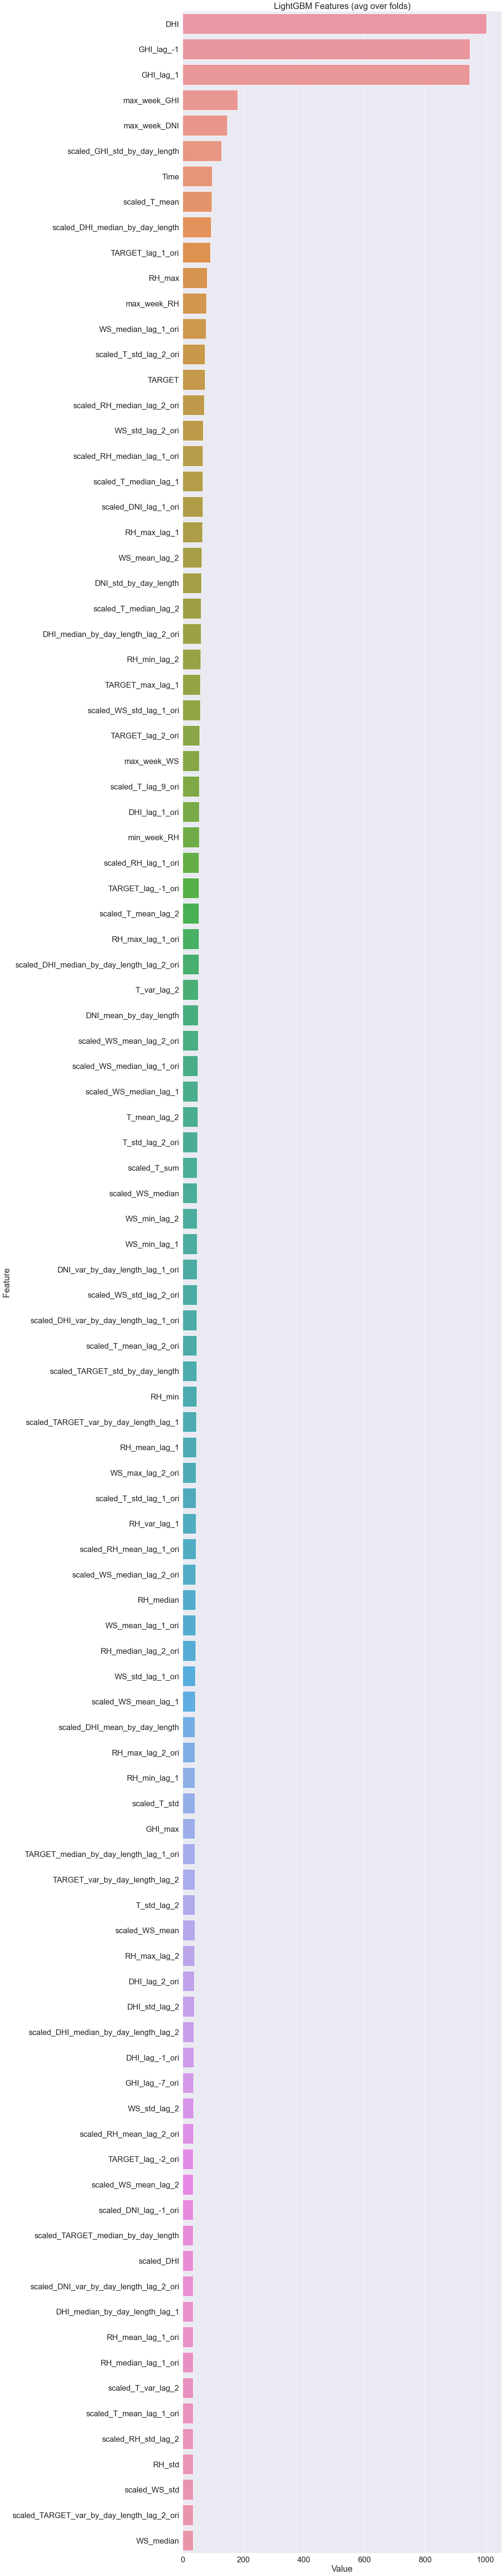

In [34]:
plotImp(models_1[4], df_predict, 100)

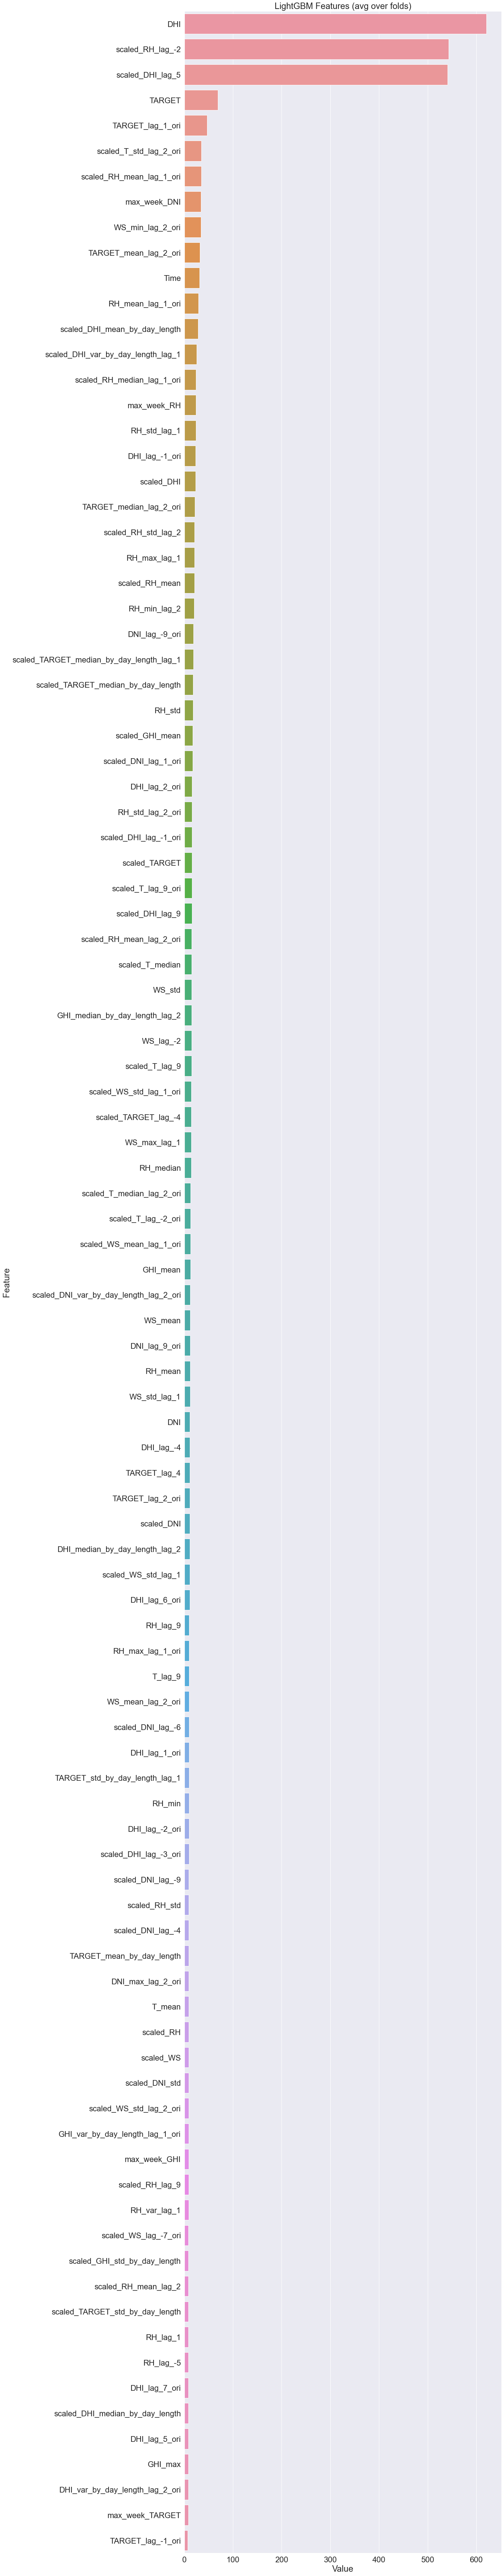

In [36]:
plotImp(model_reverse, df_predict, 100)

In [47]:
feature_imp = pd.DataFrame(models_1[4].feature_importances_).T
feature_imp.columns = models_1[4].feature_name_

In [52]:
feature_imp_reverse = pd.DataFrame(model_reverse.feature_importances_).T
feature_imp_reverse.columns = model_reverse.feature_name_

In [53]:
imp = pd.concat([feature_imp, feature_imp_reverse])